# Sentimental Analysis for NLP

In [1]:
#import libraries
import pandas as pd
import numpy as np
import string
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import  LinearSVC
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from nltk.stem.snowball import SnowballStemmer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.naive_bayes import MultinomialNB
import seaborn as sn
import matplotlib.pyplot as plt
#from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import  BernoulliNB
#from sklearn.naive_bayes import  ComplementNB

## Functions to be used in this program

In [2]:
def count_digits(string):
    """Counts digits in pandas column"""
    return sum(item.isdigit() for item in string)

def dedupe_list(x):
    """Dedupes a list"""
    return list(dict.fromkeys(x))


## Step 1. Data preparation & understanding

1. Check NAs
2. Remove puncutation and digits
3. Exclude words that are not likely to affect sentiment
4. Ensure program is not case sensitive: will put everything to lower case in this instance. Also considered using str.casefold()
5. Stemming
7. Train and test split
6. Vectorisation


#### 1.1. Firstly I will look at the data - how many rows it has, also check for NAs

In [3]:
#import data
reviews = pd.read_csv('car_reviews.csv')
#create and id
reviews["id"] = np.arange(len(reviews))
# create a random number that will be used for test & train split:
reviews['randNumCol'] = np.random.randint(1,100, size=len(reviews))
print("Total number of rows:", len(reviews))
print("Number of NAs in the rviews file:", len(reviews) - len(reviews.dropna()))

Total number of rows: 1382
Number of NAs in the rviews file: 0


#### 1.2,1.3 and 1.4. Remove punctuation and digits, exclude non significant words, ensure program is not case sensitive

To show punctuation removal I will count total. Punctation to be removed: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' 

Chose to remove digits too as probably unlikely to affect the review and might make it difficult for the classifier to handle.


In [4]:
#Count puncation and digits
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
reviews['count_punct'] = reviews.Review.apply(lambda s: count(s, string.punctuation))
reviews['count_digits'] = reviews['Review'].apply(count_digits)
print("Total punctuation count before removal:", reviews['count_punct'].sum())
print("Total digit count before removal:", reviews['count_digits'].sum())

Total punctuation count before removal: 2
Total digit count before removal: 37713


It appears punctuation has been removed from the initial csv file. I will apply punctuation removal function anyway as it is good practice - in case a different csv file is tested. I have created a separate column so we can compare punctuation and digit counts before and after.
To produce the output to clearly demonstarte that words and punctuation, which are unlikely to affect sentiment, have been excluded from sentiment classfier AND that the remaining words are handled in a case sensitive way. 

In [5]:
#remove punctuation and make all lower case
reviews["review_clean"] = reviews['Review'].str.replace('[^\w\s]','').str.lower()
reviews['count_punct'] = reviews.Review.apply(lambda s: count(s, string.punctuation))
print("Total punctuation count after removal:", reviews['count_punct'].sum())
#remove digits
reviews['review_clean'] = reviews['review_clean'].str.replace('\d+', '')
reviews['count_digits'] = reviews['review_clean'].apply(count_digits)
print("Total digit count after removal:", reviews['count_digits'].sum())


#reviews['review_clean'] = reviews['review_clean'].str.lower()
#remove stop words
stop = text.ENGLISH_STOP_WORDS
reviews['review_clean_without_stopwords'] = reviews['review_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print()
print("Example before punctuation and digit removal and converting to lower case:")
print(reviews["Review"].head())
print()
print("Example after punctuation and digit removal and converting to lower case:")
print(reviews["review_clean_without_stopwords"].head())


C:\Users\vinod munirajaiah\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\vinod munirajaiah\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


Total punctuation count after removal: 2
Total digit count after removal: 0

Example before punctuation and digit removal and converting to lower case:
0     In ?1992 we !bought a new Taurus and we reall...
1     The last business trip  I drove to San Franci...
2     My husband and I purchased a 1990 Ford F250 a...
3     I feel I have a thorough opinion of this truc...
4     AS a mother of 3  all of whom are still in ca...
Name: Review, dtype: object

Example after punctuation and digit removal and converting to lower case:
0    bought new taurus really loved decided try new...
1    business trip drove san francisco went hertz r...
2    husband purchased ford f problems owned vehicl...
3    feel thorough opinion truck compared post eval...
4    mother carseats logical thing trade sx minivan...
Name: review_clean_without_stopwords, dtype: object


 ### 1.5. Stemming

After removing digits, I can see some "words" have become i letter words - for exampke, Ford250 became f (row index 2 is an example). I will remove any 1 letter words.
For stemming I chose Snowball stemmer as it is more aggresive than PorterStemmer and more stable than LancasterStemmer. 
Commas are INTENTIONALLY added between each word (tokenized) for stemming purpose and review_clean_without_stopwords becomes a list.
The process is:
1. Show how the chosen stemmer works for the mark: I have chosen a singlle review to illustrate the point - also handpicked few stems
2. Remove 1 letter words
3. Apply stemmer
4. Print before and after examples to further show it works

Screen grab below in case the order of rows changes for some reason.

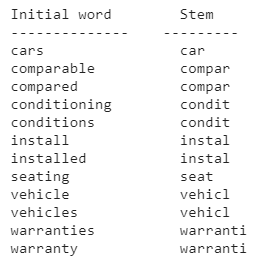

----Firstly, show that chosen stemming technique works based on example in the given csv----

In [6]:
#Show how the chosen stemmer works for the mark
stem_test=reviews['review_clean_without_stopwords'].iloc[3] # select a review to illustarte stemmimg
stem_test_tokens = sorted(dedupe_list(stem_test.split())) #sorting and deduping list for simpler reading

print("{0:20}{1:20}".format("Initial word","Stem"))
print("--------------    ---------")
stemmer =SnowballStemmer("english")
for word in stem_test_tokens:
    if word != stemmer.stem(word): # only showing different words
        if stemmer.stem(word) in ["compar","condit","instal","warranti","vehicl","car","seat"]: # manually picked few more common words in this review
            print ("{0:20}{1:20}".format(word, stemmer.stem(word)))

Initial word        Stem                
--------------    ---------
cars                car                 
comparable          compar              
compared            compar              
conditioning        condit              
conditions          condit              
install             instal              
installed           instal              
seating             seat                
vehicle             vehicl              
vehicles            vehicl              
warranties          warranti            
warranty            warranti            


----Secondly, apply stemming to each review -----

In [7]:
# remove any 1 letter words - as defined above
reviews['review_clean_without_stopwords'] = reviews['review_clean_without_stopwords'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')
#set stemmer
stemmer = SnowballStemmer("english")
#apply stemmer
reviews['stemmed'] = reviews['review_clean_without_stopwords'].str.split().apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
print("Example before stemming")
print(reviews["review_clean_without_stopwords"].head())
print()
print("Example after stemming")
print(reviews["stemmed"].head())

C:\Users\vinod munirajaiah\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


Example before stemming
0    bought new taurus really loved decided try new...
1    business trip drove san francisco went hertz r...
2    husband purchased ford problems owned vehicle ...
3    feel thorough opinion truck compared post eval...
4    mother carseats logical thing trade sx minivan...
Name: review_clean_without_stopwords, dtype: object

Example after stemming
0    [bought, new, taurus, realli, love, decid, tri...
1    [busi, trip, drove, san, francisco, went, hert...
2    [husband, purchas, ford, problem, own, vehicl,...
3    [feel, thorough, opinion, truck, compar, post,...
4    [mother, carseat, logic, thing, trade, sx, min...
Name: stemmed, dtype: object


### 1.6. Split into test and train
This has to be done before vectorisation to avoid data leakage. 
First, we need to make sure the data is in the right shape, need to unlist the tokens within each column for each review.



In [8]:
print("Putting list into string, will introduce punctuation..")
print()
reviews['count_punct'] = reviews.stemmed.apply(lambda s: count(s, string.punctuation))
print("Total punctuation count before removal:", reviews['count_punct'].sum())
print()
reviews['stemmed']= reviews['stemmed'].apply(', '.join)
reviews["stemmed"] = reviews['stemmed'].str.replace('[^\w\s]','').str.lower()
reviews['count_punct'] = reviews.stemmed.apply(lambda s: count(s, string.punctuation))
print("Total punctuation count after removal:", reviews['count_punct'].sum())
print(reviews['stemmed'])

Putting list into string, will introduce punctuation..

Total punctuation count before removal: 0



C:\Users\vinod munirajaiah\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


Total punctuation count after removal: 0
0       bought new taurus realli love decid tri new ta...
1       busi trip drove san francisco went hertz renta...
2       husband purchas ford problem own vehicl approx...
3       feel thorough opinion truck compar post evalu ...
4       mother carseat logic thing trade sx minivan mi...
                              ...                        
1377    june bought soni limit edit focus se dr sedan ...
1378    mile decid replac wife toyota camri new camri ...
1379    ford focus great littl record set car car win ...
1380    need new car hyundai excel decid shop nice sma...
1381    ford focus se door sedan spacious interior sol...
Name: stemmed, Length: 1382, dtype: object


Now will split into test and Train. 
Please note a separate column with a random number was created when the file was read in - column names "randNumCol". 80 is the % cutoff as per task spec. 
First, we sort values by the random column, then we select train and test.

In [9]:
reviews = reviews.sort_values(by=['randNumCol'])
train_size = round(len(reviews)*0.8,0)
test_size = len(reviews)-train_size
print(train_size)
print(test_size)
train_x =  reviews[:int(train_size)]["stemmed"]
train_y = reviews[:int(train_size)]['Sentiment']
test_x = reviews[:int(test_size)]['stemmed'] 
test_y = reviews[:int(test_size)]['Sentiment']
print(train_x)
print(train_y)
print(test_x)
print(test_y)


1106.0
276.0
383    own coupl ford taurus great roadtrip long comm...
837    ve ranger bought consid great invest contracto...
186    ford explor taken lot heat media late great pr...
985    vehicl car own motorcycl motorhom pickup truck...
475    rememb groceri store came generic can good qui...
                             ...                        
138    son bought ford ranger month ago doubt use car...
98     bought vehicl use mile modest los angel look g...
617    own american car bought ford zx year old son d...
614    recent went test drove puppi random thought ex...
165    amaz internet resourc realiz wide spread probl...
Name: stemmed, Length: 1106, dtype: object
383    Neg
837    Pos
186    Neg
985    Pos
475    Neg
      ... 
138    Neg
98     Neg
617    Neg
614    Neg
165    Neg
Name: Sentiment, Length: 1106, dtype: object
383     own coupl ford taurus great roadtrip long comm...
837     ve ranger bought consid great invest contracto...
186     ford explor taken lot heat 

Printing out some summary stats for marks..

In [10]:
print("Checking train and validation split..")
print("Train: ", round(len(train_x)/len(reviews)*100,0),"%", ", ",len(train_x), " records.")
print("Test: ", round(len(test_y)/len(reviews)*100,0),"%", ", ",len(test_y), " records.")
print()


Checking train and validation split..
Train:  80.0 % ,  1106  records.
Test:  20.0 % ,  276  records.



### 1.7. Vectorisation 

Use "bag of words" technique for cleaned up split data data. I will use numerical count of word as oppose to binary numbers.
Firstly, I would like to understand how many unique words we are dealing with so we know expected vector length.
Secondly, I will apply vectorisation to train dataset using CountVectorizer and exclude "uncommon words" - % to be excluded is trial and error:

I have tried:
- excluding bottom 1% of words reduces vector length by 79%: keeping 99% of words
- excluding bottom 5% of words reduces vector length by 93%: keeping 95% of words.
I have chosen to exclude bottom 5% of words, so my unique word count is reduced from 8772 to 611 (please note these numbers will vary each run due to random test and validation split, its the % that is important). I have double checked and this does not affect model accuracy.

To avoid data leakage I apply vectorisation to the training dataset which creates a voculabulary based on training dataset alone (thats why its important to split test and train before Vectorisation). Then we apply the same vocabulary to testing dataset to get vectors to validate agains. 
To demonstarte that vocabularies are the same we will compare bagged word data frames for train and test. 
In addition, this will mean that any words that appear on testing BUT NOT TRAINING will be EXCLUDED from the model build - this is how my code copes with stems that appear in the test and not train dataset. This approach should work fine as test and train are selected at random and train is 4 times larger than test, we would not expect new "significant" words to appear in the test dataset.

In [11]:
#check unique words
print("Training data set has ", len(pd.DataFrame(train_x).stemmed.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0)), " unique words")

Training data set has  8865  unique words


Vectorisation below. I have chosen to count the words and also exclude bottom 5% as per note above.

In [12]:
#I have tried different min_df, chosen 5%, might reduce for task 2
vectorizer = CountVectorizer(min_df=0.05) #exclude bottom 5%

# first, fit to traininf datastet
train_x_vector = vectorizer.fit_transform(train_x)
bagOFwords_train = pd.DataFrame(train_x_vector.toarray())
bagOFwords_train.columns = vectorizer.get_feature_names()

#then apply the same vectorisation to test data set to avoid data leakage
test_x_vector = vectorizer.transform(test_x)
bagOFwords_test = pd.DataFrame(test_x_vector.toarray())
bagOFwords_test.columns = vectorizer.get_feature_names()


Show that the same vobulary has been applied to test dataset by 
- comparing number of columns (which are unique words in the train dataset) in train and test BOW
- comparing column names in train and test BOW

In [13]:
print("Number of columns in training BOW: ", len(bagOFwords_train.columns))
print("Number of columns in testing BOW: ", len(bagOFwords_test.columns))
print()
print("Comparing if columns match..")
if(list(bagOFwords_train.columns) ==list(bagOFwords_test.columns)):
    print("Column names match exactly, therefore no data leakage expected")
else:
    print("Column names do not match exactly, data leakage expected")
print()    
print("We now need to convert data into array/vector to use for model, an example of how this is done is below..")
print("When we convert full training df we should expect ",len(train_x), " vectors - thats how many reviews in our training data frame.")
print("Checking on full training df we get....", len(np.asarray([np.asarray(bagOFwords_train)])[0]), " vectors")
print()
print("Few vector examples below...")
print("Review 1: ", np.asarray([np.asarray(bagOFwords_train)][0][0]))
print("Review 2: ", np.asarray([np.asarray(bagOFwords_train)][0][1]))



Number of columns in training BOW:  626
Number of columns in testing BOW:  626

Comparing if columns match..
Column names match exactly, therefore no data leakage expected

We now need to convert data into array/vector to use for model, an example of how this is done is below..
When we convert full training df we should expect  1106  vectors - thats how many reviews in our training data frame.
Checking on full training df we get.... 1106  vectors

Few vector examples below...
Review 1:  [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

#### Step 2. Simple sentiment classifier
1. Build classifier; as per spec Naive Bayes model
2. Output confusion matrix

In [14]:
mnb=MultinomialNB()
mnb.fit(bagOFwords_train,train_y)
predicted = mnb.predict(bagOFwords_test)
acc_score = accuracy_score(predicted,test_y)
print("Accuracy of Naive Bayes model: ", round(acc_score*100,2), "%")

Accuracy of Naive Bayes model:  80.07 %


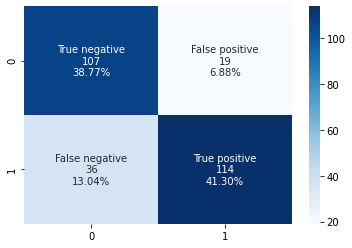

In [15]:
conf_mat = confusion_matrix(predicted, test_y)
group_names = ['True negative','False positive',"False negative","True positive"]
group_counts = ['{0:0.0f}'.format(value) for value in
                conf_mat.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_mat.flatten()/np.sum(conf_mat)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sn.heatmap(conf_mat, annot=labels, fmt="", cmap='Blues')
